## Exercice: Time Series Modeling.

In [ ]:
# Importing Libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing


import warnings
warnings.filterwarnings("ignore")

In [107]:
# Data Loading and Understanding:

In [108]:
# load data
df = pd.read_csv(r"C:\Users\sanas\OneDrive\Desktop\DSC630 datasets\us_retail_sales.csv")

# display first few rows
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [109]:
# display the number of rows and columns
df.shape
print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns")

The data contains 30 rows and 13 columns


In [110]:
# display the columns
df.columns

Index(['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC'],
      dtype='object')

In [111]:
# Overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    30 non-null     int64  
 1   JAN     30 non-null     int64  
 2   FEB     30 non-null     int64  
 3   MAR     30 non-null     int64  
 4   APR     30 non-null     int64  
 5   MAY     30 non-null     int64  
 6   JUN     30 non-null     int64  
 7   JUL     29 non-null     float64
 8   AUG     29 non-null     float64
 9   SEP     29 non-null     float64
 10  OCT     29 non-null     float64
 11  NOV     29 non-null     float64
 12  DEC     29 non-null     float64
dtypes: float64(6), int64(7)
memory usage: 3.2 KB


In [112]:
# check for missing data
df.isnull().sum()

YEAR    0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     1
AUG     1
SEP     1
OCT     1
NOV     1
DEC     1
dtype: int64

In [113]:
# check for duplicates
df.duplicated().sum()

0

In [114]:
# Data cleaning:

In [115]:
# handling missing data 
df.tail()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
25,2017,416081,415503,414620,416889,414540,416505,416744.0,417179.0,426501.0,426933.0,431158.0,433282.0
26,2018,432148,434106,433232,435610,439996,438191,440703.0,439278.0,438985.0,444038.0,445242.0,434803.0
27,2019,440751,439996,447167,448709,449552,450927,454012.0,456500.0,452849.0,455486.0,457658.0,458055.0
28,2020,460586,459610,434281,379892,444631,476343,481627.0,483716.0,493327.0,493991.0,488652.0,484782.0
29,2021,520162,504458,559871,562269,548987,550782,NaN,NaN,NaN,NaN,NaN,NaN


Only the last row includes missing data. Regarding that we need the data for all the period since January 1992 until June 2021 in later steps, we will replace the null values with the mean of each column.

In [116]:
columns_to_transform = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
for column in columns_to_transform:
    df[column] = df[column].fillna(df[column].mean())
    

In [117]:
# transform the data into long format

In [118]:
# Convert from Wide to Long format
df_long = df.melt(id_vars=["YEAR"], var_name="MONTH", value_name="Sales")

# Convert MONTH names to numerical values for sorting
month_order = {
    "JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
    "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12
}
df_long["MONTH"] = df_long["MONTH"].map(month_order)

# Sort by YEAR and MONTH
df_long = df_long.sort_values(by=["YEAR", "MONTH"])

# Calculate Monthly Change
#df_long["MONTHLY_CHANGE"] = df_long.groupby("YEAR")["VALUE"].diff()

# Display the transformed DataFrame
print(df_long.head(15))

     YEAR  MONTH     Sales
0    1992      1  146925.0
30   1992      2  147223.0
60   1992      3  146805.0
90   1992      4  148032.0
120  1992      5  149010.0
150  1992      6  149800.0
180  1992      7  150761.0
210  1992      8  151067.0
240  1992      9  152588.0
270  1992     10  153521.0
300  1992     11  153583.0
330  1992     12  155614.0
1    1993      1  157555.0
31   1993      2  156266.0
61   1993      3  154752.0


In [119]:
# Data Visualization: Plot the data with proper labeling and make some observations on the graph.

In [120]:
## Yearly Retail Sales:

In [121]:
# group data by year and sum the sales
grouped_by_year = df_long.groupby('YEAR')['Sales'].sum()
grouped_by_year

YEAR
1992    1.804929e+06
1993    1.936304e+06
1994    2.103260e+06
1995    2.220214e+06
1996    2.355746e+06
1997    2.470772e+06
1998    2.582652e+06
1999    2.801416e+06
2000    2.979385e+06
2001    3.062153e+06
2002    3.129617e+06
2003    3.261614e+06
2004    3.460884e+06
2005    3.686580e+06
2006    3.876561e+06
2007    3.997356e+06
2008    3.927636e+06
2009    3.612988e+06
2010    3.816558e+06
2011    4.101990e+06
2012    4.297036e+06
2013    4.459586e+06
2014    4.636514e+06
2015    4.724104e+06
2016    4.832576e+06
2017    5.045935e+06
2018    5.256332e+06
2019    5.411662e+06
2020    5.581438e+06
2021    5.085640e+06
Name: Sales, dtype: float64

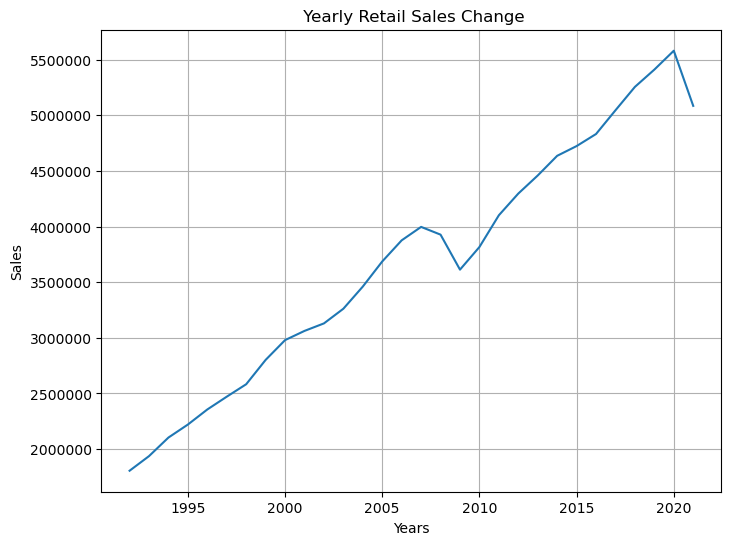

In [122]:
# creating a line plot yearly retail sales
plt.figure(figsize=(8,6))
grouped_by_year.plot(kind='line')
#plt.bar(grouped_by_year.index, grouped_by_year.values)
plt.xlabel("Years")
plt.ylabel("Sales")
plt.title(" Yearly Retail Sales Change")
plt.ticklabel_format(style='plain', axis='y')
plt.grid()
plt.show()

The line plot illustrates the trend in total retail sales from 1992 to 2021, showing a steady upward trajectory. However, this growth was briefly interrupted by a decline of approximately $400,000 in 2009, followed by a strong recovery that culminated in a peak in 2020.

In [123]:
# Monthly Change of Retail Sales

In [124]:
# group by month and compute the average monthly sales
grouped_by_month = df_long.groupby('MONTH')['Sales'].mean()
grouped_by_month

MONTH
1     304803.833333
2     305200.900000
3     307533.566667
4     306719.600000
5     309205.633333
6     311406.966667
7     304375.448276
8     305451.965517
9     306078.206897
10    307310.620690
11    307794.896552
12    308099.620690
Name: Sales, dtype: float64

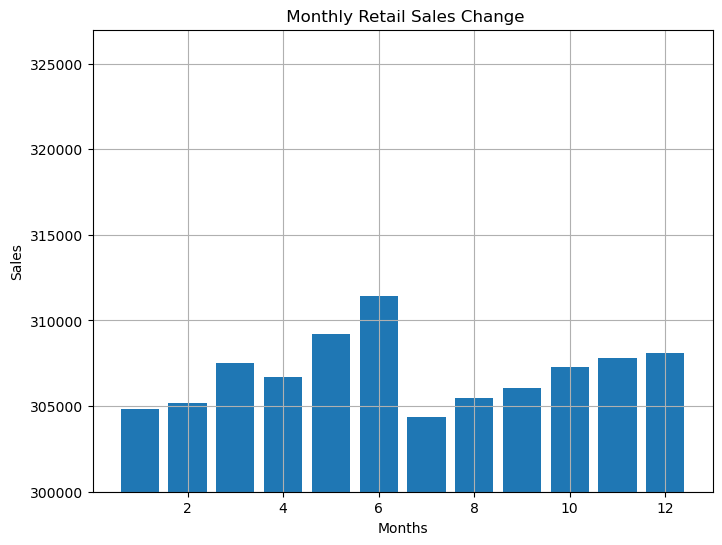

In [125]:
# creating bar plot monthly retail sales
plt.figure(figsize=(8,6))
#grouped_by_month.plot( kind='line')

plt.bar(grouped_by_month.index, grouped_by_month.values)
plt.ylim(300000, None)
plt.xlabel("Months")
plt.ylabel("Sales")
plt.title(" Monthly Retail Sales Change")
plt.ticklabel_format(style='plain', axis='y')
plt.grid()
plt.show()

The highest sales were recorded in June, exceeding $310,000 , while July experienced the lowest sales, totaling $304,000.

In [126]:
# Split this data into a training and test set.
#Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [127]:
df_long.head()

,YEAR,MONTH,Sales
0,1992,1,146925.0
30,1992,2,147223.0
60,1992,3,146805.0
90,1992,4,148032.0
120,1992,5,149010.0


In [128]:
#define the features and target variable
X= df_long.drop(columns='Sales')
y= df_long['Sales'] # target var

In [129]:
train_set = df_long[(df_long['YEAR']<2020)| ((df_long['YEAR']==2020) & (df_long['MONTH']<7))]
test_set = df_long[(df_long['YEAR']==2020) & (df_long['MONTH']>=7) | (df_long['YEAR']==2021) & (df_long['MONTH']<=6)]
                                                                      # Display shapes to verify the split
print("Training Set:", train_set.shape)
print("Test Set:", test_set.shape)

Training Set: (342, 3)
Test Set: (12, 3)


In [80]:
#Data Modeling: SARIMAX and Holt Winters models

In [130]:
# Use the training set to build a predictive model for the monthly retail sales.

In [131]:
# Convert YEAR and MONTH into a datetime index
df_long['DATE'] = pd.to_datetime(df_long[['YEAR', 'MONTH']].assign(DAY=1))
df_long = df_long[['DATE', 'Sales']].set_index('DATE')

In [132]:
df_long.head()

,Sales
DATE,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


In [133]:
# Train-Test Split (Ensuring Proper Filtering)
train_set = df_long.loc[:'2020-06']
test_set = df_long.loc['2020-07':'2021-06']

print("Training Set:", train_set.shape)
print("Test Set:", test_set.shape)

Training Set: (342, 1)
Test Set: (12, 1)


Before training the model, we need to tune its parameters values p, d, q.

In [46]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [134]:



# Grid search parameters for SARIMAX
p = range(0, 3)  
d = range(0, 2)  
q = range(0, 3)  
seasonal_p = range(0, 3)
seasonal_d = range(0, 2)
seasonal_q = range(0, 3)
seasonal_period = [12] 

best_sarimax_rmse = float("inf")
best_sarimax_params = None
best_sarimax_model = None

# Grid Search for SARIMAX
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_period):
        try:
            model = SARIMAX(train_set['Sales'], order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            predictions = results.predict(start=test_set.index[0], end=test_set.index[-1])
            
            rmse = np.sqrt(mean_squared_error(test_set['Sales'], predictions))
            
            if rmse < best_sarimax_rmse:
                best_sarimax_rmse = rmse
                best_sarimax_params = (order, seasonal_order)
                best_sarimax_model = results

            print(f"SARIMAX{order}x{seasonal_order} - RMSE: {rmse}")
        
        except Exception as e:
            print(f"Error with SARIMAX{order}x{seasonal_order}: {e}")
            continue

print(f"\nBest SARIMAX Model: {best_sarimax_params} with RMSE: {best_sarimax_rmse}")




SARIMAX(0, 0, 0)x(0, 0, 0, 12) - RMSE: 515310.1509549047
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - RMSE: 292788.8443887231
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - RMSE: 199828.0103206737
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - RMSE: 80273.26429193803
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - RMSE: 82940.41897060524
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - RMSE: 86090.05413375069
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - RMSE: 69041.49859203277
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - RMSE: 70322.03859688262
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - RMSE: 72213.77948633209
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - RMSE: 85568.56826920451
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - RMSE: 82941.39134841168
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - RMSE: 78926.48751761309
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - RMSE: 72099.8510446164
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - RMSE: 72042.2717561894
SARIMAX(0, 0, 0)x(2, 0, 2, 12) - RMSE: 72206.66846243622
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - RMSE: 83635.063082284
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - RMSE: 78463.16662441236
SARIMAX(0, 0, 0)x(2, 1, 2, 12) - RM

In [135]:
# Grid search parameters for Holt-Winters (Triple Exponential Smoothing)
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [12]  

best_hw_rmse = float("inf")
best_hw_params = None
best_hw_model = None

# Grid Search for Holt-Winters
for trend, seasonal in itertools.product(trend_options, seasonal_options):
    if seasonal is None and trend is None:
        continue  # Skip models without trend or seasonality

    for period in seasonal_periods:
        try:
            model = ExponentialSmoothing(train_set['Sales'], trend=trend, seasonal=seasonal, seasonal_periods=period)
            results = model.fit()
            predictions = results.predict(start=test_set.index[0], end=test_set.index[-1])
            
            rmse = np.sqrt(mean_squared_error(test_set['Sales'], predictions))
            
            if rmse < best_hw_rmse:
                best_hw_rmse = rmse
                best_hw_params = (trend, seasonal, period)
                best_hw_model = results

            print(f"Holt-Winters (Trend: {trend}, Seasonal: {seasonal}, Period: {period}) - RMSE: {rmse}")

        except Exception as e:
            print(f"Error with Holt-Winters (Trend: {trend}, Seasonal: {seasonal}, Period: {period}): {e}")
            continue

print(f"\nBest Holt-Winters Model: {best_hw_params} with RMSE: {best_hw_rmse}")



Holt-Winters (Trend: add, Seasonal: add, Period: 12) - RMSE: 45156.97171858639
Holt-Winters (Trend: add, Seasonal: mul, Period: 12) - RMSE: 45345.01278558456
Holt-Winters (Trend: add, Seasonal: None, Period: 12) - RMSE: 45681.7496779458
Holt-Winters (Trend: mul, Seasonal: add, Period: 12) - RMSE: 38637.65063086934
Holt-Winters (Trend: mul, Seasonal: mul, Period: 12) - RMSE: 38867.92445476479
Holt-Winters (Trend: mul, Seasonal: None, Period: 12) - RMSE: 38459.371317475096
Holt-Winters (Trend: None, Seasonal: add, Period: 12) - RMSE: 50242.87027301101
Holt-Winters (Trend: None, Seasonal: mul, Period: 12) - RMSE: 50842.88197960182

Best Holt-Winters Model: ('mul', None, 12) with RMSE: 38459.371317475096



Best Model: SARIMAX ((1, 0, 1), (0, 0, 1, 12)) with RMSE: 17947.33684719224


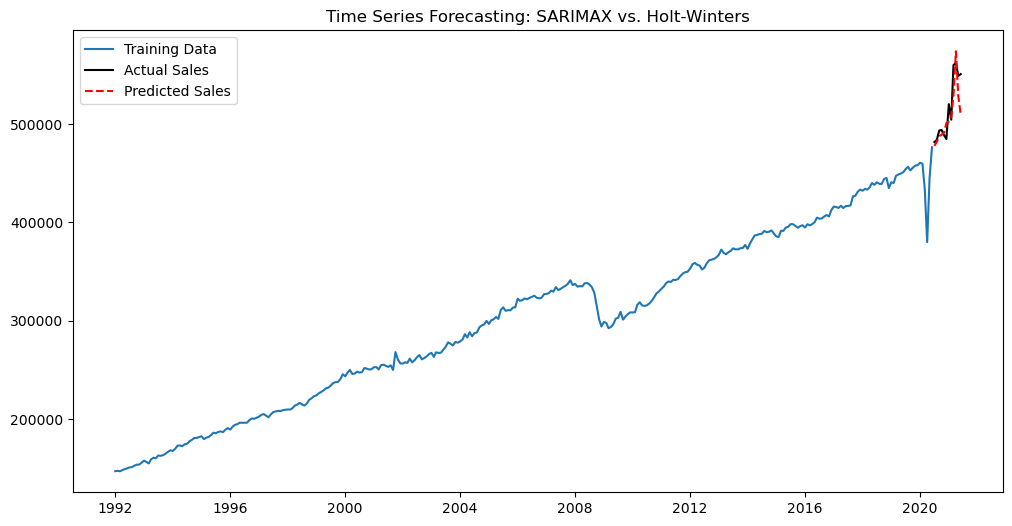

In [136]:
# Compare Models
if best_sarimax_rmse < best_hw_rmse:
    print(f"\nBest Model: SARIMAX {best_sarimax_params} with RMSE: {best_sarimax_rmse}")
    final_model = best_sarimax_model
    final_predictions = final_model.predict(start=test_set.index[0], end=test_set.index[-1])
else:
    print(f"\nBest Model: Holt-Winters {best_hw_params} with RMSE: {best_hw_rmse}")
    final_model = best_hw_model
    final_predictions = final_model.predict(start=test_set.index[0], end=test_set.index[-1])

# Plot Predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Sales'], label="Training Data")
plt.plot(test_set.index, test_set['Sales'], label="Actual Sales", color='black')
plt.plot(test_set.index, final_predictions, label="Predicted Sales", color='red', linestyle='dashed')
plt.legend()
plt.title("Time Series Forecasting: SARIMAX vs. Holt-Winters")
plt.show()